#  Wholesale Manager

**Author:**
[Anthony Strittmatter](http://www.anthonystrittmatter.com)

You take the role of a wholesale store manager. The data file juice.csv contains orange juice sales (sales) and prices (price) of different grocery stores that you deliver. Your product range contains three different orange juice brands: Tropicana, Minute Maid, and Dominicks. Some stores advertise/feature specific orange juice brands, which is indicated by the dummy variable feat. The data contains also the store ID (id). You deliver new grocery stores. The new stores sent you the file new grocery.csv, which contains the planned prices and advertisements for the different brands. Your job as wholesale manager is to predict the sales of the new grocery stores and deliver the right amount of orange juice.

## Load Packages and Data

In [11]:
########################  Load Packages and Data  ########################

# Load packages
library(rpart)
library(rpart.plot)
library(grf)
library(glmnet)

# Load data
juice <- read.csv("juice.csv", sep = ",")
new_grocery <- read.csv("new_grocery.csv", sep = ",")

print('Packages and data successfully loaded.')

#############################################################################

[1] "Packages and data successfully loaded."


## Inspect Data

In [2]:
########################  Describe Old Data  ########################

# Print first few rows of old data
head(juice)

# Number of observations
print(paste0('Old data: ',nrow(juice),' observations'))

######################################################################

X,id,sales,price,brand,feat
1,1140,11970,2.47,minute.maid,0
3,7182,30205,1.57,dominicks,1
4,1741,3521,2.55,minute.maid,0
5,1725,11777,1.41,dominicks,0
6,7565,129151,2.05,minute.maid,1
8,5617,7104,3.74,tropicana,0


[1] "Old data: 9685 observations"


In [3]:
########################  Describe Old Data  ########################

# Print first few rows of new data
head(new_grocery)

# Number of observations
print(paste0('New data: ',nrow(new_grocery),' observations'))

######################################################################

X,id,price,brand,feat
2,10171,1.81,dominicks,1
7,7489,NA,tropicana,0
10,7559,3.29,tropicana,0
11,1236,1.77,minute.maid,1
16,5361,1.53,dominicks,0
17,108,1.42,dominicks,0


[1] "New data: 3262 observations"


## Prepare Data

In [4]:
########################  Data Preparation  ########################

# Generate dummy for missing prices
missing <- (is.na(juice$price) == TRUE)
new_missing <- (is.na(new_grocery$price) == TRUE)

# Replace missing prices with zero
juice$price[is.na(juice$price)] <-0
new_grocery$price[is.na(new_grocery$price)] <-0

# Generate Dummies for Brands
brand_1 <- (juice$brand == "minute.maid")
brand_2 <- (juice$brand == "dominicks")
brand_3 <- (juice$brand == "tropicana")

new_brand_1 <- (new_grocery$brand == "minute.maid")
new_brand_2 <- (new_grocery$brand == "dominicks")
new_brand_3 <- (new_grocery$brand == "tropicana")

# Generate outcome and control variables
y <- as.matrix(juice$sales)
colnames(y) <- c("sales")

x <- as.matrix(cbind(juice$price, missing, brand_1, brand_2, brand_3, juice$feat))
colnames(x) <- c("price", "missing", "minute.maid", "dominicks", "tropicana", "featured")

new_x <- as.matrix(cbind(new_grocery$price, new_missing, new_brand_1, new_brand_2, new_brand_3, new_grocery$feat))
colnames(new_x) <- c("price", "missing", "minute.maid", "dominicks", "tropicana", "featured")

# Descriptive statistics
summary(cbind(y,x))

print('Data is prepared.')

#############################################################################

     sales            price          missing         minute.maid    
 Min.   :    63   Min.   :0.000   Min.   :0.00000   Min.   :0.0000  
 1st Qu.:  4800   1st Qu.:1.710   1st Qu.:0.00000   1st Qu.:0.0000  
 Median :  8256   Median :2.120   Median :0.00000   Median :0.0000  
 Mean   : 17023   Mean   :2.174   Mean   :0.04801   Mean   :0.3284  
 3rd Qu.: 16896   3rd Qu.:2.720   3rd Qu.:0.00000   3rd Qu.:1.0000  
 Max.   :716415   Max.   :4.170   Max.   :1.00000   Max.   :1.0000  
   dominicks        tropicana        featured     
 Min.   :0.0000   Min.   :0.000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:0.0000  
 Median :0.0000   Median :0.000   Median :0.0000  
 Mean   :0.3405   Mean   :0.331   Mean   :0.2355  
 3rd Qu.:1.0000   3rd Qu.:1.000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :1.000   Max.   :1.0000  

[1] "Data is prepared."


**$\Rightarrow$ It is possible to add non-linear and interaction terms.**

## Generate Training and Test Sample

In [5]:
########################  Training and Test Samples  ########################

set.seed(1001)

# Generate variable with the rows in training data
size <- floor(0.5 * nrow(juice))
training_set <- sample(seq_len(nrow(juice)), size = size)

print('Training and test samples created.')

#############################################################################

[1] "Training and test samples created."


## Predict Orange Juice Prices in Training Sample and Assess Model in Test Sample

### Lasso, Ridge, Elastic Net

In [6]:
########################  LASSO, Ridge, Elastic Net  ##############################

set.seed(27112019)
penalized.cv <- cv.glmnet(x[training_set,],y[training_set], 
                      type.measure = "mse", family = "gaussian", nfolds = 10, alpha = 0.5)


# Fitted values
pred_penalized <- predict(penalized.cv, newx = x, s = penalized.cv$lambda.min, alpha = 0.5)

# Calculate the MSE
MSE_penalized <- mean((y[-training_set] - pred_penalized[-training_set])^2)
R2_penalized <- round(1- MSE_penalized/var(y[-training_set]), digits = 3)

print(paste0("R-squared Penalized Regression: ", R2_penalized))
                                   
################################################################

[1] "R-squared Penalized Regression: 0.278"


### Tree

[1] "R-squared Tree: 0.336"


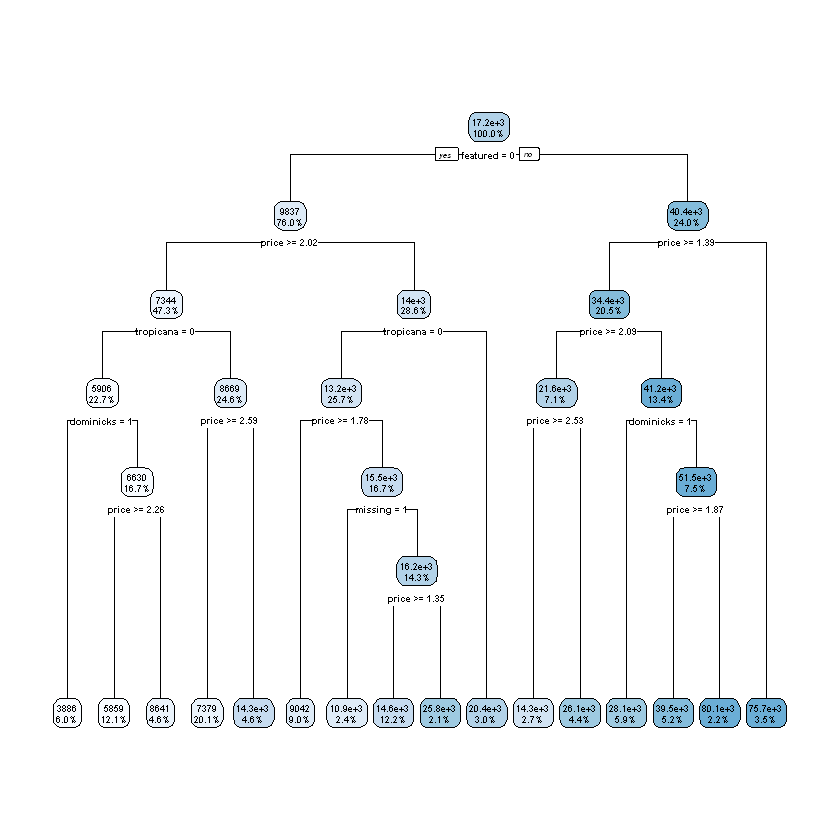

In [7]:
######################  Regression Tree  #######################

set.seed(27112019)

# Prepare data for tree estimator
outcome <- y[training_set]
tree_data <- data.frame(outcome, x[training_set,])

deep_tree <- rpart(formula = outcome ~ ., data = tree_data, method = "anova",
                y = TRUE, control = rpart.control(xval = 10, cp = 0.00002, minbucket=100))

# Optimal tree size
op.index <- which.min(deep_tree$cptable[, "xerror"])

## Select the Tree that Minimises CV-MSE
cp.vals <- deep_tree$cptable[op.index, "CP"]

# Prune the deep tree
pruned_tree <- prune(deep_tree, cp = cp.vals)

## Plot tree structure
rpart.plot(pruned_tree,digits=3)

# Fitted values
predtree <- predict(pruned_tree, newdata= as.data.frame(x))

# Calculate the MSE
MSEtree <- mean((y[-training_set] - predtree[-training_set])^2)
R2tree <- round(1- MSEtree/var(y[-training_set]), digits = 3)

print(paste0("R-squared Tree: ", R2tree))

################################################################

### Random Forest

In [8]:
########################  Random Forest  #######################

set.seed(27112019)

rep <- 1000 # number of trees
cov <- 2/3 # share of covariates
frac <- 1/2 # fraction of subsample
min_obs <- 10 # max. size of terminal leaves in trees

# Build Forest
forest <- regression_forest(x[training_set,], y[training_set,], mtry = floor(cov*ncol(x)), sample.fraction = frac,
            num.trees = rep, min.node.size = min_obs, honesty=FALSE)

# Fitted values
predforest <- predict(forest, newdata=x)$predictions

# Calculate MSE
MSEforest <- mean((y[-training_set] - predforest[-training_set])^2)
R2forest <- round(1- MSEforest/var(y[-training_set]), digits = 3)

print(paste0("R-squared Forest: ", R2forest))

################################################################

[1] "R-squared Forest: 0.411"


## Select Favorite Model and Extrapolate to New Data

In [9]:
########################  Out-of-Sample Prediction  #######################

# Fitted values
# We select Random Forest because highest R-squared
new_prediction <- predict(forest, newdata = new_x)$predictions

print('Out-of-sample sales are predicted.')

###########################################################################

[1] "Out-of-sample sales are predicted."


## Store Out-of-Sample Predictions

In [10]:
########################  Store Results  #######################

id_new <- as.matrix(new_grocery$id)

# Replace ??? with your last name
write.csv(cbind(id_new,new_prediction),"strittmatter.csv")

print('File is stored.')

################################################################

[1] "File is stored."
